# Notebook to classify a GEE image using trained sklearn model. 

### This is achieved by downloading an earth engine image in patches, running inference on the patch and then mosaicing all image patches together 

# Import packages

In [1]:
import geemap
import ee
ee.Initialize()
import numpy as np
import pandas as pd
import json
import os
import glob
import earthpy as et
import matplotlib.pyplot as plt
from pycaret.regression import load_model,plot_model
import rasterio as rio
from rasterio.merge import merge
from rasterio.plot import reshape_as_raster, reshape_as_image

In [2]:
Map = geemap.Map()
Map

Map(center=[40, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value=…

# Import data

In [3]:
# Import AOI
aoi = ee.FeatureCollection('users/jdmwhite/KNP_study_area')
Map.addLayer(aoi)

In [4]:
# Import covariate to be classified
covariates = ee.Image('users/jdmwhite/WTWTA_covariates_1000_sel')

In [5]:
#  Load model
model = load_model(r"D:\My_projects\Rhinos_KNP\Final ET Model 04_Aug_2021")

Transformation Pipeline and Model Successfully Loaded


# Generate patch size grid

In [6]:
# Generate a random image of integers in Albers projection at the specified cell size.
seed = 123
spatial_res = 1000 #in metres
num_pixels = 8
cellSize = num_pixels*spatial_res

proj = ee.Projection("EPSG:3857").atScale(cellSize)
cells = ee.Image.random(seed).multiply(1e6).int().clip(aoi).reproject(proj)
Map.addLayer(cells.randomVisualizer())

In [7]:
# Convert to feature collection to allow for looping

grid = cells.reduceToVectors(**{ 'geometry': aoi})
Map.addLayer(grid)

# Classify patches

Generating URL ...
Please wait ...
Data downloaded to D:\My_projects\Rhinos_KNP\data\692842.tif


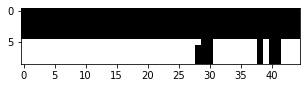

Generating URL ...
Please wait ...
Data downloaded to D:\My_projects\Rhinos_KNP\data\782412.tif


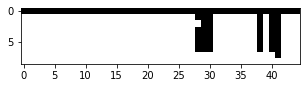

Generating URL ...


KeyboardInterrupt: 

In [13]:
def patch_classify (model, covariates, save_path, ee_grid):
    """
    Classify patches of imagery from google earth engine using a scikit-learn model
    
    model(scikit-learn model): A trained scikit learn model
    covariates(ee.Image): The image to run inference on
    save_path(string): directory to store predict patches
    ee_fc_grid(ee.FeatureCollection):A feature collection with blocks the size of the required patch size
    """
    out_dir = str(save_path)
    bandnames = covariates.bandNames().getInfo()
    # Get grid id's
    fid = ee_grid.aggregate_array('label').getInfo()
    
    for cell_id in fid:
        ft = ee.Feature(ee_grid.filter(ee.Filter.eq('label', cell_id)).first())
        clipped = covariates.clip(ft)
        # Download patch as tif ()
        geemap.ee_export_image(clipped, filename= os.path.join(out_dir, f"{cell_id}.tif"), scale=1000, region= ee.Feature(ft).geometry(), file_per_band=False)
        # Read patch
        with rio.open(os.path.join(out_dir, f"{cell_id}.tif")) as src:
            i_arr = src.read()
            i_arr = reshape_as_image(i_arr)
            i_meta = src.profile
        # enhance and show the image
        vmin, vmax = np.nanpercentile(i_arr, (5,95))  # 5-95% contrast stretch
        # show the enhanced image
        plt.figure(figsize=[5,5])
        plt.imshow(i_arr[0], cmap='gray', vmin=vmin, vmax=vmax)
        plt.show()
        # Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
        new_arr = i_arr.reshape(i_arr.shape[0]*i_arr.shape[1], i_arr.shape[-1])#reshape 3d array to 2d array that matches the training data table from earlier
        # classify image
        class_prediction = model.predict(pd.DataFrame(new_arr, columns = bandnames).fillna(0))
        # Reshape our classification map back into a 2D matrix so we can visualize it
        class_prediction = class_prediction.reshape(i_arr[:, :, 0].shape).astype(np.float32)
        # save output as a Gtif
        i_meta.update(count=1)
        with rio.open(os.path.join(out_dir, f"pred{cell_id}.tif"), 'w', **i_meta) as dst:
            dst.write(class_prediction, 1)

patch_classify(model, covariates, "D:\My_projects\Rhinos_KNP\data", grid)

# Mosaic output tifs

In [63]:
dirpath = r"D:\My_projects\Rhinos_KNP\data"

out_fp = r"D:\My_projects\Rhinos_KNP\data\class_Mosaic.tif"

# Make a search criteria to select the processed files
search_criteria = r"D:\My_projects\Rhinos_KNP\data/**/pred*.tif"

q = os.path.join(dirpath, search_criteria)

print(q)

D:\My_projects\Rhinos_KNP\data/**/pred*.tif


In [64]:
fps = glob.glob(q, recursive=True)
fps

['D:\\My_projects\\Rhinos_KNP\\data\\pred105170.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred10920.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred110549.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred112736.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred113784.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred11707.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred11770.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred125614.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred13290.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred133328.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred13683.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred143280.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred154975.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred156110.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred161168.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred163104.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred171297.tif',
 'D:\\My_projects\\Rhinos_KNP\\data\\pred176141.tif',
 'D:\\My_projects\\Rhinos_KNP\\da

In [65]:
src_files_to_mosaic = []
for fp in fps:
    src = rasterio.open(fp)
    src_files_to_mosaic.append(src)

In [66]:
# Merge function returns a single mosaic array and the transformation info
mosaic, out_trans = merge(src_files_to_mosaic)

In [67]:
# Convert to project string using earthpy
proj4 = et.epsg['4326']#'32634'
print(proj4)

+proj=longlat +datum=WGS84 +no_defs


In [68]:
out_meta = src.meta.copy()
# Update the metadata
out_meta.update({"driver": "GTiff",
                  "height": mosaic.shape[1],
                  "width": mosaic.shape[2],
                  "transform": out_trans,
                 "crs": str(proj4)})

In [69]:
with rasterio.open(out_fp, "w", **out_meta) as dest:
     dest.write(mosaic)

# Upload mosaic to GEE

In [55]:
# Create metadata file
!geeup getmeta --input "D:\My_projects\Rhinos_KNP" --metadata "D:\My_projects\Rhinos_KNP\metadata.csv"

Building cache. Hang on . . .
Done
Processed: 1 of 1


File type 'ArcGISProjectFile' not found or no open command associated with it.
Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.
File type 'ArcGISProjectFile' not found or no open command associated with it.
Error processing line 1 of c:\programdata\anaconda3\envs\tfgpu\lib\site-packages\ArcGISPro.pth:

  Traceback (most recent call last):
    File "c:\programdata\anaconda3\envs\tfgpu\lib\site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "c:\programdata\anaconda3\envs\tfgpu\lib\site-packages\arcpy_init.py", line 61, in set_pro_paths
      install_dir = pro_install_dir()
    File "c:\programdata\anaconda3\envs\tfgpu\lib\site-packages\arcpy_init.py", line 49, in pro_install_dir
      aprx_ftype = subprocess.check_output(["ftype", "ArcGISProjectFile"], shell=True)
    File "c:\programdata\anaconda3\envs\tfgpu\lib\subprocess.py", line 336,

In [59]:
# Upload image to GEE
!geeup upload --source "D:\My_projects\Rhinos_KNP" --dest "users/geethensingh/WTWTA_static_HS" --metadata "D:\My_projects\Rhinos_KNP\metadata.csv" -u "geethen.singh@gmail.com"

Building cache. Hang on . . .
Done


File type 'ArcGISProjectFile' not found or no open command associated with it.
Python was not found; run without arguments to install from the Microsoft Store, or disable this shortcut from Settings > Manage App Execution Aliases.
File type 'ArcGISProjectFile' not found or no open command associated with it.
Error processing line 1 of c:\programdata\anaconda3\envs\tfgpu\lib\site-packages\ArcGISPro.pth:

  Traceback (most recent call last):
    File "c:\programdata\anaconda3\envs\tfgpu\lib\site.py", line 168, in addpackage
      exec(line)
    File "<string>", line 1, in <module>
    File "c:\programdata\anaconda3\envs\tfgpu\lib\site-packages\arcpy_init.py", line 61, in set_pro_paths
      install_dir = pro_install_dir()
    File "c:\programdata\anaconda3\envs\tfgpu\lib\site-packages\arcpy_init.py", line 49, in pro_install_dir
      aprx_ftype = subprocess.check_output(["ftype", "ArcGISProjectFile"], shell=True)
    File "c:\programdata\anaconda3\envs\tfgpu\lib\subprocess.py", line 336,